# Random Forest Classifier

# Table of Content

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

In [3]:
raw_data = pd.read_pickle(r'..\HW1_Decision Tree\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data.fillna(0.0,inplace=True)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## Define label: $y \in \{-1,1\}$
Insert a column in the data set where the entries are： (1) 1 if the stock outperforms SPY in the earnings period; (2) -1 if it underperforms or has the same return

In [4]:
def f(x):
    if x > 0:
        return 1
    else:
        return -1

In [5]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

## RandomForestClassifier with given hyperparameters

From the GridSearch for RandomForestClassifier result in the course file, the best hyperparameter set is:
- `max_depth = 5`
- `max_features = 'log2'` 
- `n_estimators = 40`   
- `min_samples_leaf = 1200`

Therefore, I will use this set of hyperparameters and combine it with different optimal features.

In [7]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

## Different combinations of hyperparameters and optimal features

### (1) Use optimal features given by `opt_feat_1.pkl`

In [8]:
with open(r'opt_feature_files\opt_feat_1.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [9]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):
    
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

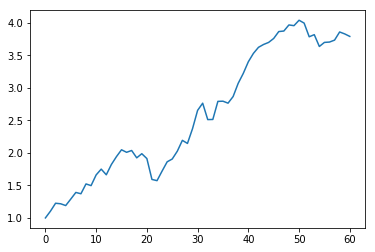

In [10]:
plt.plot(x[1:]);

In [12]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

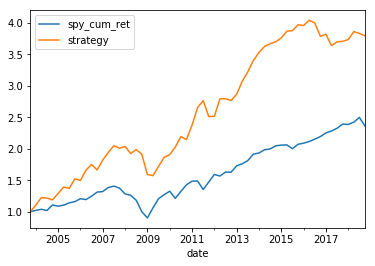

In [13]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [14]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.8508186514040487


#### Compute maximal yearly drawdown

In [15]:
def max_drawdown(s):
    L = len(s)
    minus = []
    for i in range(L-1):
        minus.append(s[i+1]-s[i])
    for i in range(1,L-1):
        if minus[i]<0 and minus[i-1]<0:
            minus[i] += minus[i-1]
    if min(minus)<0:
        return -min(minus)
    else:
        return 0

In [16]:
max_drawdown(SPY['strategy'])

0.2633343469803169

### (2) Use optimal features given by `opt_feat_2.pkl`

In [17]:
with open(r'opt_feature_files\opt_feat_2.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [18]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):
    
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

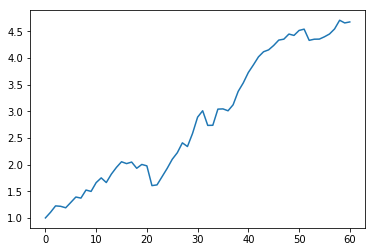

In [19]:
plt.plot(x[1:]);

In [20]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

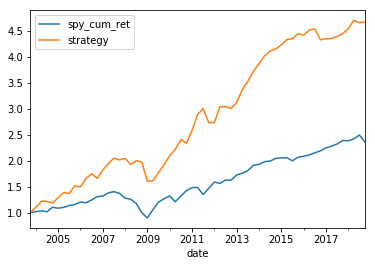

In [21]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [22]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.128905409530057


#### Compute maximal yearly drawdown

In [23]:
max_drawdown(SPY['strategy'])

0.1182265610204416

### (3) Use optimal features given by `opt_feat_3.pkl`

In [24]:
with open(r'opt_feature_files\opt_feat_3.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [25]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):
    
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

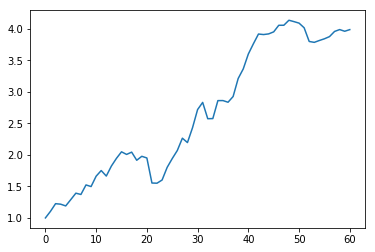

In [26]:
plt.plot(x[1:]);

In [27]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

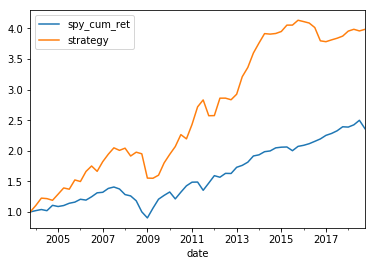

In [28]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [29]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7658085310027848


#### Compute maximal yearly drawdown

In [30]:
max_drawdown(SPY['strategy'])

0.3365753890047265

### (4) Use optimal features given by `opt_feat_4.pkl`

In [31]:
with open(r'opt_feature_files\opt_feat_4.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [32]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):
    
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

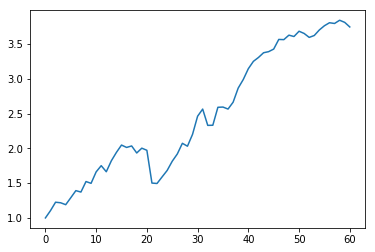

In [33]:
plt.plot(x[1:]);

In [34]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

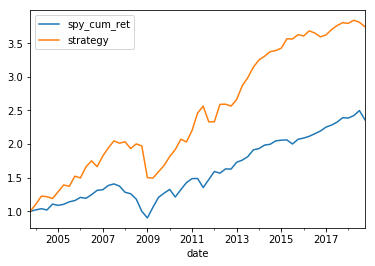

In [35]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [36]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.8558107260030396


#### Compute maximal yearly drawdown

In [37]:
max_drawdown(SPY['strategy'])

0.33086382523817237

### (5) Use optimal features given by `opt_feat_5.pkl`

In [38]:
with open(r'opt_feature_files\opt_feat_5.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [39]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):
    
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

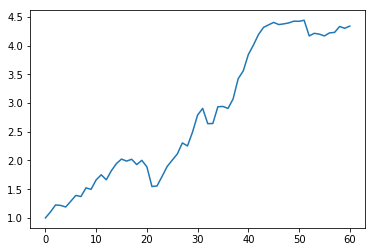

In [40]:
plt.plot(x[1:]);

In [41]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

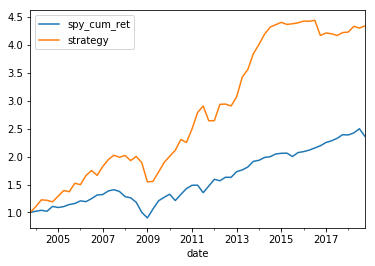

In [42]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [43]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7930069483566082


#### Compute maximal yearly drawdown

In [44]:
max_drawdown(SPY['strategy'])

0.22673915784757614

### (6) Use optimal features given by `opt_feat_6.pkl`

In [45]:
with open(r'opt_feature_files\opt_feat_6.pkl','rb') as f:
    optimal_features = pickle.load(f)

In [46]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):
    
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

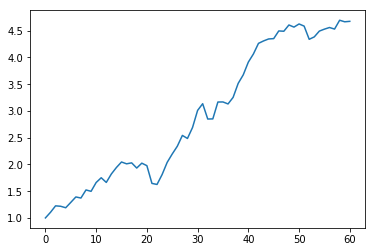

In [47]:
plt.plot(x[1:]);

In [48]:
SPY = pd.read_pickle(r'..\HW1_Decision Tree\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

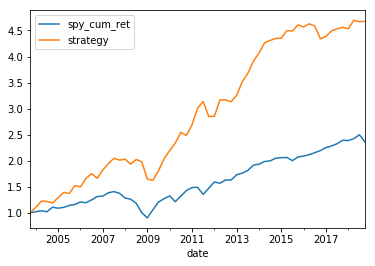

In [49]:
SPY.plot();

#### Compute strategy Sharpe Ratio

In [50]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.0221208776072643


#### Compute maximal yearly drawdown

In [51]:
max_drawdown(SPY['strategy'])

0.26784830897532164

## Results

- The best performing strategy is given by optimal feature set: `opt_feat_2.pkl`
- Its yearly maximal drawdown is about 0.1182
- And its Sharpe Ratio is about 1.1289, which is larger than 1